In [1]:
import pandas as pd

from scipy import stats
from acquire import acquire_telco_churn_data
from prepare import prepare_telco_data
from utilities import generate_xy_splits, nan_null_empty_check, evaluate_hypothesis_pcorrelation, evaluate_hypothesis_ttest
from explore import explore_univariate, explore_bivariate, explore_multivariate

# Attention Grabbing Title

## Agenda
1. Executive Summary
2. Data Science Pipeline
3. Conclusion

## Executive Summary

## Planning
The Agile Kanban methodology was used to map out the tasks for this project. The Kanban board used can be found <a href="https://trello.com/b/ipr1KRLX/classification-project">here</a>.
We planned to test the following:
1. Dependency between month-to-month contracts and churn
    * Null hypothesis - Churn is independent of month-to-month contracts.
    * Alternative hypothesis - Month-to-month contracts and churn are dependent on each other.
2. Dependency between fiber and churn
    * Null hypothesis - Churn is independent of fiber service.
    * Alternative hypothesis - Fiber service and churn are dependent on each other.
3. Correlation between tenure and monthly charges
    * Null hypothesis - Monthly charges do not correlate with tenure.
    * Alternative hypothesis - Monthly charges and tenure have a correlation.
4. Month-to-month fiber customers and monthly charges
    * Null hypothesis - Month-to-month fiber customers do not pay more in monthly charges than other customers.
    * Alternative hypothesis - Month-to-month fiber customers do pay higher monthly charges than other customers.

#### Data Dictionary
    <table>
        <tr>
            <th>col</th>
            <th>val</th>
        </tr>
        <tr>
            <th>row</th>
            <td>data</td>
        </tr>
    </table>

## Acquisition
Data was obtained from the from the `telco_churn` database using this query:
> `SELECT *
       FROM customers
           JOIN contract_types USING(contract_type_id)
           JOIN internet_service_types USING(internet_service_type_id)
           JOIN payment_types USING(payment_type_id);`

We scripted the acquisition with the `acquire_telco_churn_data` function.

In [2]:
telco_df = acquire_telco_churn_data()

In [3]:
telco_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 25 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Unnamed: 0                7043 non-null   int64  
 1   payment_type_id           7043 non-null   int64  
 2   internet_service_type_id  7043 non-null   int64  
 3   contract_type_id          7043 non-null   int64  
 4   customer_id               7043 non-null   object 
 5   gender                    7043 non-null   object 
 6   senior_citizen            7043 non-null   int64  
 7   partner                   7043 non-null   object 
 8   dependents                7043 non-null   object 
 9   tenure                    7043 non-null   int64  
 10  phone_service             7043 non-null   object 
 11  multiple_lines            7043 non-null   object 
 12  online_security           7043 non-null   object 
 13  online_backup             7043 non-null   object 
 14  device_p

The `info` function told us that we had mostly `str` values that would need to be encoded. Also, 25 columns seemed a little high to manage effectively. `Unnamed: 0`, `payment_type_id`, `internet_service_type_id`, `contract_type_id`, `multiple_lines`, and `customer_id` were identified as redundant or irrelevant and were marked for dropping in the next phase.

The non-null counts led us to believe that there were no missing values, however, the `nan_null_empty_check` utility revealed there were columns with empty strings as values:

In [4]:
missing_positions = nan_null_empty_check(telco_df)
print(missing_positions)

{'nan_positions': (array([], dtype=int64), array([], dtype=int64)), 'empty_positions': (array([1878, 1949, 2029, 2048, 2132, 6143, 6569, 6605, 6615, 6686, 6895]), array([20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20]))}


This result told us that there were empty strings as values in the rows listed above (the first array under the `empty_positions` key) all belonging to column 20 (`total_charges`). These values were identified as needing cleaning in the Preparation phase.

A random sample showed us that some columns that seemed binary actually had a third value ("No internet service" or "No phone service") that would need to be simplified.

In [5]:
telco_df.sample(10)

,Unnamed: 0,payment_type_id,internet_service_type_id,contract_type_id,customer_id,gender,senior_citizen,partner,dependents,tenure,...,tech_support,streaming_tv,streaming_movies,paperless_billing,monthly_charges,total_charges,churn,contract_type,internet_service_type,payment_type
139,139,1,1,1,1310-QRITU,Female,0,No,No,18,...,No,No,No,Yes,50.30,913.3,No,Month-to-month,DSL,Electronic check
610,610,4,1,1,4957-TREIR,Male,0,No,No,3,...,Yes,Yes,No,Yes,64.40,195.65,No,Month-to-month,DSL,Credit card (automatic)
622,622,1,1,1,5057-LCOUI,Female,0,No,No,39,...,No,Yes,Yes,Yes,50.75,2011.4,Yes,Month-to-month,DSL,Electronic check
3522,3522,4,2,1,5095-AESKG,Female,0,Yes,No,3,...,No,No,Yes,Yes,91.50,242.95,Yes,Month-to-month,Fiber optic,Credit card (automatic)
5149,5149,1,2,3,1428-IEDPR,Male,0,No,No,52,...,Yes,Yes,Yes,Yes,109.30,5731.4,No,Two year,Fiber optic,Electronic check
6674,6674,4,3,3,4086-WITJG,Male,0,Yes,Yes,71,...,No internet service,No internet service,No internet service,No,19.70,1301.1,No,Two year,None,Credit card (automatic)
824,824,4,1,1,6661-EIPZC,Female,0,Yes,Yes,48,...,Yes,No,No,Yes,29.50,1423.05,No,Month-to-month,DSL,Credit card (automatic)
3903,3903,2,2,1,6857-VWJDT,Female,0,No,No,1,...,No,Yes,Yes,No,95.65,95.65,Yes,Month-to-month,Fiber optic,Mailed check
1518,1518,4,1,2,5170-PTRKA,Female,0,Yes,Yes,49,...,Yes,No,No,Yes,35.80,1782,No,One year,DSL,Credit card (automatic)
2731,2731,3,2,1,1482-OXZSY,Male,0,No,No,30,...,No,Yes,Yes,Yes,100.40,2936.25,No,Month-to-month,Fiber optic,Bank transfer (automatic)


## Preparation

We prepared the data by addressing the issues identified in the acquisition phase. First, we pulled the relevant information from the rows with missing values.

In [6]:
rows = missing_positions['empty_positions'][0]
telco_df.iloc[rows][['tenure', 'monthly_charges', 'total_charges']]

,tenure,monthly_charges,total_charges
1878,0,56.05,
1949,0,61.90,
2029,0,73.35,
2048,0,52.55,
2132,0,80.85,
6143,0,19.70,
6569,0,20.00,
6605,0,20.25,
6615,0,25.35,
6686,0,25.75,


Since these rows all had a tenure of 0, we assumed that `total_charges` was equal to `monthly_charges` and set them equal to each other. The `total_charges` column was then converted to float values.

The `Unnamed: 0`, `payment_type_id`, `internet_service_type_id`, `contract_type_id`, `multiple_lines`, and `customer_id` were dropped since they contained redundant or information not deemed useful.

We combined `online_backup`, `online_security`, `device_protection`, and `tech_support` into `internet_extras` to simplify the features and remove the need to deal with the "No internet service" values. Similarly, `streaming_movies` and `streaming_tv` were combinged into `streaming_entertainment`.

The `partner` and `dependents` columns were combined into the `family` column.

Finally, the non-numerical columns were encoded into numerical values and the new columns were renamed to remove spaces.

These changes were scripted into the `prepare_telco_data` function.

In [7]:
train, validate, test = prepare_telco_data(telco_df)

## Explore

Univariate exploration was performed using the `explore_univariate` function:

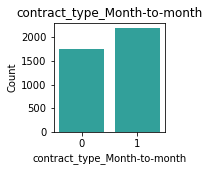

   contract_type_Month-to-month  Count  Percent
1                             1   2192    55.59
0                             0   1751    44.41
_________________________________________________________________


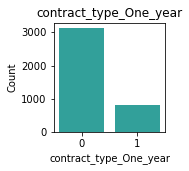

   contract_type_One_year  Count  Percent
0                       0   3122    79.18
1                       1    821    20.82
_________________________________________________________________


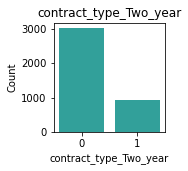

   contract_type_Two_year  Count  Percent
0                       0   3013    76.41
1                       1    930    23.59
_________________________________________________________________


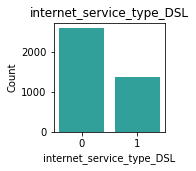

   internet_service_type_DSL  Count  Percent
0                          0   2578    65.38
1                          1   1365    34.62
_________________________________________________________________


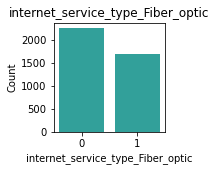

   internet_service_type_Fiber_optic  Count  Percent
0                                  0   2246    56.96
1                                  1   1697    43.04
_________________________________________________________________


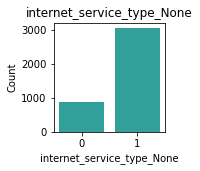

   internet_service_type_None  Count  Percent
0                           1   3062    77.66
1                           0    881    22.34
_________________________________________________________________


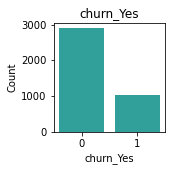

   churn_Yes  Count  Percent
0          0   2897    73.47
1          1   1046    26.53
_________________________________________________________________


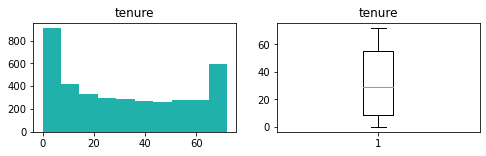

count    3943.000000
mean       32.143799
std        24.434152
min         0.000000
25%         9.000000
50%        29.000000
75%        55.000000
max        72.000000
Name: tenure, dtype: float64


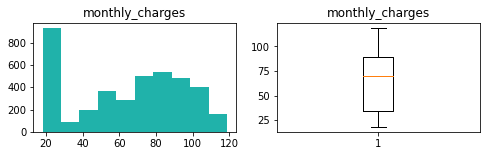

count    3943.000000
mean       64.191910
std        30.003617
min        18.250000
25%        34.700000
50%        70.050000
75%        89.425000
max       118.650000
Name: monthly_charges, dtype: float64


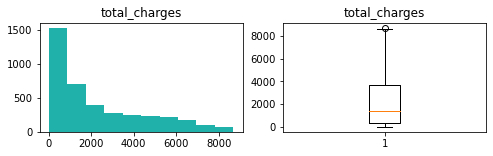

count    3943.000000
mean     2237.319706
std      2230.492855
min        18.900000
25%       399.350000
50%      1386.800000
75%      3676.625000
max      8684.800000
Name: total_charges, dtype: float64


In [8]:
cat_vars = ['contract_type_Month-to-month', 'contract_type_One_year', 'contract_type_Two_year', 'internet_service_type_DSL', 'internet_service_type_Fiber_optic', 'internet_service_type_None', 'churn_Yes']
quant_vars = ['tenure', 'monthly_charges', 'total_charges']
target = 'churn_Yes'

explore_univariate(train, cat_vars, quant_vars)

This exploration revealed that most customers had month-to-month contracts and fiber optic internet service. We also saw that tenure, monthly charges, and total charges were far from normally distributed. For the most part, these variables were skewed to the right.

#### Hypothesis testing

We used a confidence level of 95% to test our hypotheses.

In [9]:
alpha = .05

In [11]:
# Dependency between month-to-month contracts and churn
null_hyp = "Churn is independent of month-to-month contracts."
alt_hyp = "Month-to-month contracts and churn are dependent on each other."

observed = pd.crosstab(train.churn_Yes, train['contract_type_Month-to-month'])
chi2, p, degf, expected = stats.chi2_contingency(observed)

print(f"p value is less than alpha:  {p < alpha}")

p value is less than alpha:  True


In [12]:
# Dependency between fiber and churn
null_hyp = "Churn is independent of fiber service."
alt_hyp = "Fiber service and churn are dependent on each other."

observed = pd.crosstab(train.churn_Yes, train.internet_service_type_Fiber_optic)
chi2, p, degf, expected = stats.chi2_contingency(observed)

print(f"p value is less than alpha:  {p < alpha}")

p value is less than alpha:  True


In [13]:
# Correlation between tenure and monthly charges
null_hyp = "Monthly charges do not correlate with tenure."
alt_hyp = "Monthly charges and tenure have a correlation."

corr, p = stats.pearsonr(train.monthly_charges, train.tenure)
evaluate_hypothesis_pcorrelation(corr, p, alpha=alpha, null_hypothesis=null_hyp, alternative_hypothesis=alt_hyp)

------------------------------------------
corr:  0.23760458551856645, p:  9.892794406868373e-52, a:  Monthly charges and tenure have a correlation.

We reject the null hypothesis. We move forward with the alternative hypothesis:  Monthly charges and tenure have a correlation.
Correlation direction:  positive
------------------------------------------


{'corr': 0.23760458551856645,
 'p': 9.892794406868373e-52,
 'a': 0.05,
 'reject_null': True,
 'message': 'We reject the null hypothesis. We move forward with the alternative hypothesis:  Monthly charges and tenure have a correlation.',
 'correlation': 'positive'}

In [15]:
# Month-to-month fiber customers and monthly charges 
null_hyp = "Month-to-month fiber customers do not pay more in monthly charges than other customers."
alt_hyp = "Month-to-month fiber customers do pay higher monthly charges than other customers."

monthly_fiber_customers = train[(train['contract_type_Month-to-month'] == 1) & (train.internet_service_type_Fiber_optic == 1)]
samples = monthly_fiber_customers.monthly_charges

population_mean = train.monthly_charges.mean()

t, p = stats.ttest_1samp(samples, population_mean)
evaluate_hypothesis_ttest(p, t, alpha=alpha, tails="greater", null_hypothesis=null_hyp, alternative_hypothesis=alt_hyp)

------------------------------------------
t:  70.19897136074535, p:  0.0, a:  0.05

We reject the null hypothesis. We move forward with the alternative hypothesis:  Month-to-month fiber customers do pay higher monthly charges than other customers.
------------------------------------------


{'t': 70.19897136074535,
 'p': 0.0,
 'a': 0.05,
 'message': 'We reject the null hypothesis. We move forward with the alternative hypothesis:  Month-to-month fiber customers do pay higher monthly charges than other customers.',
 'reject_null': True}

The results from the statistical testing allow us to move forward with all our alternative hypotheses:
1. Month-to-month contracts and churn are dependent on each other.
2. Fiber service and churn are dependent on each other.
3. Monthly charges and tenure have a correlation.
4. Month-to-month fiber customers do pay higher monthly charges than other customers.